### Let's demonstrate how to simulate a "micrograph" in cryojax. This will demonstrate how to use equinox to vmap over Poses

In [1]:
# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config
from jaxlie import SO3
from functools import partial

import cryojax.simulator as cs
from cryojax.io import read_array_with_spacing_from_mrc

config.update("jax_enable_x64", False)

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# Configure the image parameters
image_dim = 600
shape = (image_dim, image_dim)
pixel_size = 4.4  # Angstroms
image_size = image_dim * pixel_size

In [4]:
# Sample a group of uniform rotations and translations
keys = jax.random.split(jax.random.PRNGKey(0), 100)
# ... rotations
rotations = jax.vmap(lambda key: SO3.sample_uniform(key))(keys)
# ... translations
translations = jax.vmap(
    lambda key: jax.random.uniform(
        key, (3,), minval=-image_size / 2, maxval=image_size / 2
    )
)(keys)
translations /= jnp.asarray([1.0, 1.0, image_size / 2])

In [5]:
# Now, instantiate the poses
poses = jax.vmap(lambda R, t: cs.QuaternionPose.from_rotation_and_translation(R, t))(
    rotations, translations
)

# ... load the scattering potential and projection method
filename = "../tests/data/3j9g_bfm1_ps4_4.mrc"
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
config = cs.ImageConfig(shape, pixel_size, pad_scale=1.2)
potential = cs.FourierVoxelGrid.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=1.3
)
scattering = cs.FourierSliceExtract(config)

# ... build the specimen
specimen = cs.Specimen(potential, poses)

# ... and finally the instrument
optics = cs.WeakPhaseOptics()
instrument = cs.Instrument(optics=optics)

### Option 1: Use equinox in order to compute the image superposition

In [6]:
@partial(jax.vmap, in_axes=[0, None])
def compute_image_stack(vmap, novmap):
    """Compute image stack."""
    pipeline = eqx.combine(vmap, novmap)
    return pipeline.render()


@jax.jit
def compute_stack_and_sum(vmap, novmap):
    """Compute the stack and sum."""
    return jnp.sum(compute_image_stack(vmap, novmap), axis=0)


@jax.jit
def compute_micrograph(specimen, scattering, instrument):
    """Build the model and compute the superposition."""
    pipeline = cs.ImagePipeline(specimen, scattering, instrument)
    is_vmap = lambda x: isinstance(x, cs.AbstractPose)
    to_vmap = jax.tree_util.tree_map(is_vmap, pipeline, is_leaf=is_vmap)
    vmap, novmap = eqx.partition(pipeline, to_vmap)
    return compute_stack_and_sum(vmap, novmap)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Sum of random poses'}>)

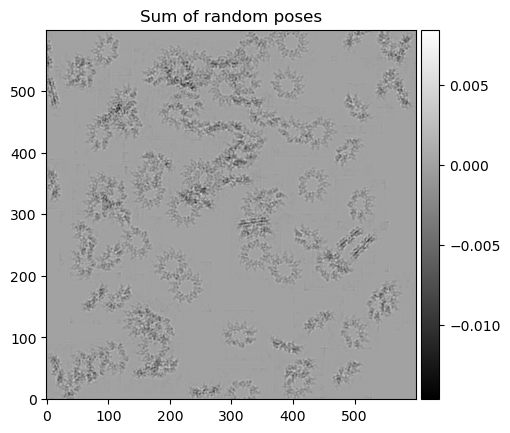

In [7]:
# Compute the image and plot
fig, ax = plt.subplots()
micrograph = compute_micrograph(specimen, scattering, instrument)
plot_image(micrograph, fig, ax, label="Sum of random poses")